# Forecasting Customer Demand in Python Time Series Modeling

## How many customers should the bank expect?

Packages used:

Orbit's Documentation: https://orbit-ml.readthedocs.io/en/latest/

In [78]:
#import pandas and numpy
import pandas as pd
import numpy as np

# From matplotlib, import pyplot under the alias plt
import matplotlib.pyplot as plt

# Reading an excel file using Python
import os

#Import library
from prophet import Prophet
from prophet.plot import plot_yearly, plot_forecast_component, add_changepoints_to_plot
from prophet.utilities import regressor_coefficients

#%matplotlib inline
import orbit
from orbit.models import LGT, DLT, ETS

from orbit.diagnostics.plot import plot_predicted_data,plot_predicted_components
from orbit.eda import eda_plot

#from orbit.models.lgt import LGTMAP, LGTAggregated
#from orbit.models.dlt import DLTMAP
from orbit.diagnostics.backtest import BackTester, TimeSeriesSplitter

import warnings
warnings.filterwarnings('ignore')

In [60]:
# Give the location of your file -

## Load a sheet into a DataFrame by name
df = pd.read_csv('datasets/creditunion.csv')

#Check results
print(df.head())

print(df.columns)

#Strip whitespace from columm names
df.columns = df.columns.str.replace(' ', '')

   MONTH  DAYMON  DAYWEEK    CUST    SPECIAL  SP  FAC  BH  AH
0      1       2        2    1825  SP,FAC,AH   1    1   0   1
1      1       3        3    1257          0   0    0   0   0
2      1       4        4     969          0   0    0   0   0
3      1       5        5    1672         SP   1    0   0   0
4      1       8        1    1098          0   0    0   0   0
Index(['MONTH', 'DAYMON', 'DAYWEEK', '  CUST', 'SPECIAL', 'SP', 'FAC', 'BH',
       'AH'],
      dtype='object')


In [61]:
#Check dataset structure
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   MONTH    254 non-null    int64 
 1   DAYMON   254 non-null    int64 
 2   DAYWEEK  254 non-null    int64 
 3   CUST     254 non-null    int64 
 4   SPECIAL  254 non-null    object
 5   SP       254 non-null    int64 
 6   FAC      254 non-null    int64 
 7   BH       254 non-null    int64 
 8   AH       254 non-null    int64 
dtypes: int64(8), object(1)
memory usage: 18.0+ KB
None


In [62]:
#Add year to dataframe
df['year'] = 1990

print(df.head(10))

   MONTH  DAYMON  DAYWEEK  CUST    SPECIAL  SP  FAC  BH  AH  year
0      1       2        2  1825  SP,FAC,AH   1    1   0   1  1990
1      1       3        3  1257          0   0    0   0   0  1990
2      1       4        4   969          0   0    0   0   0  1990
3      1       5        5  1672         SP   1    0   0   0  1990
4      1       8        1  1098          0   0    0   0   0  1990
5      1       9        2   691          0   0    0   0   0  1990
6      1      10        3   672          0   0    0   0   0  1990
7      1      11        4   754          0   0    0   0   0  1990
8      1      12        5   972          0   0    0   0   0  1990
9      1      15        1   816          0   0    0   0   0  1990


In [63]:
#Add date column
#Need to concatenate columns to make a year month day string
df['date_string'] = df['year'].astype(str) + df['MONTH'].astype(str) + df['DAYMON'].astype(str)

#check results
print(df.head(10))

   MONTH  DAYMON  DAYWEEK  CUST    SPECIAL  SP  FAC  BH  AH  year date_string
0      1       2        2  1825  SP,FAC,AH   1    1   0   1  1990      199012
1      1       3        3  1257          0   0    0   0   0  1990      199013
2      1       4        4   969          0   0    0   0   0  1990      199014
3      1       5        5  1672         SP   1    0   0   0  1990      199015
4      1       8        1  1098          0   0    0   0   0  1990      199018
5      1       9        2   691          0   0    0   0   0  1990      199019
6      1      10        3   672          0   0    0   0   0  1990     1990110
7      1      11        4   754          0   0    0   0   0  1990     1990111
8      1      12        5   972          0   0    0   0   0  1990     1990112
9      1      15        1   816          0   0    0   0   0  1990     1990115


In [64]:
#Now let's convert our date string to a proper datetime object
df['date']= pd.to_datetime(df['date_string'], format = '%Y%m%d')

#Check results
print(df['date'].head(10))

0   1990-01-02
1   1990-01-03
2   1990-01-04
3   1990-01-05
4   1990-01-08
5   1990-01-09
6   1990-01-10
7   1990-11-01
8   1990-11-02
9   1990-11-05
Name: date, dtype: datetime64[ns]


In [65]:
#Copy CUST column to new column and change column name to n_customers
df['n_customers'] = df['CUST']
#df.rename(columns = {'CUST': "customer_count"})

print(df.head(2))

   MONTH  DAYMON  DAYWEEK  CUST    SPECIAL  SP  FAC  BH  AH  year date_string  \
0      1       2        2  1825  SP,FAC,AH   1    1   0   1  1990      199012   
1      1       3        3  1257          0   0    0   0   0  1990      199013   

        date  n_customers  
0 1990-01-02         1825  
1 1990-01-03         1257  


## Exploratory Data Analysis

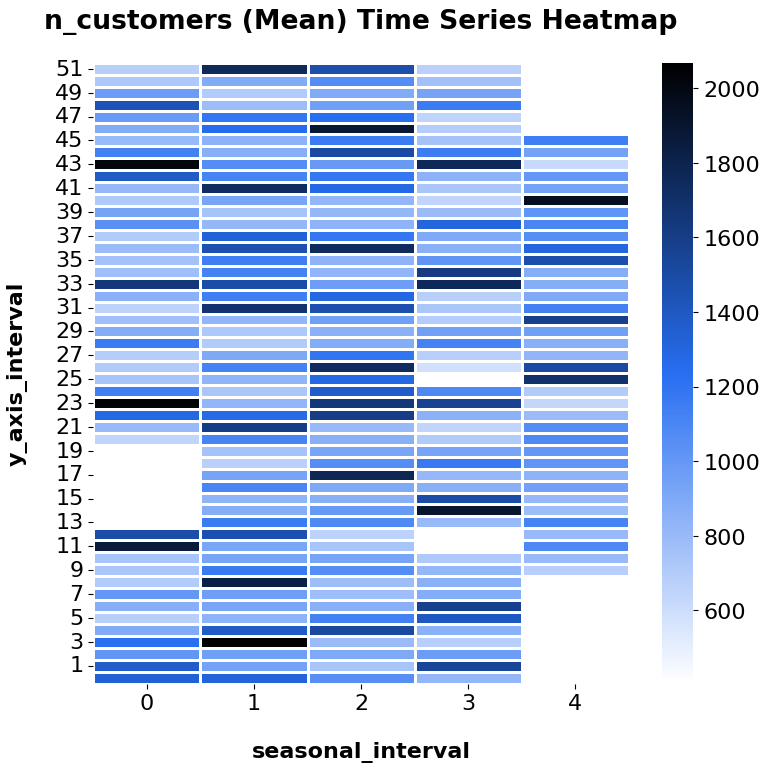

In [67]:
#Print edaplot as a heatmap
_ = eda_plot.ts_heatmap(df = df, date_col = 'date', seasonal_interval=52, value_col='n_customers')

Here we are heatmapping number of customers over the entire 52 weeks by each day of the week which is Monday - Friday which is why we have only 5 values on the x-axis and the y-axis has 52 values.

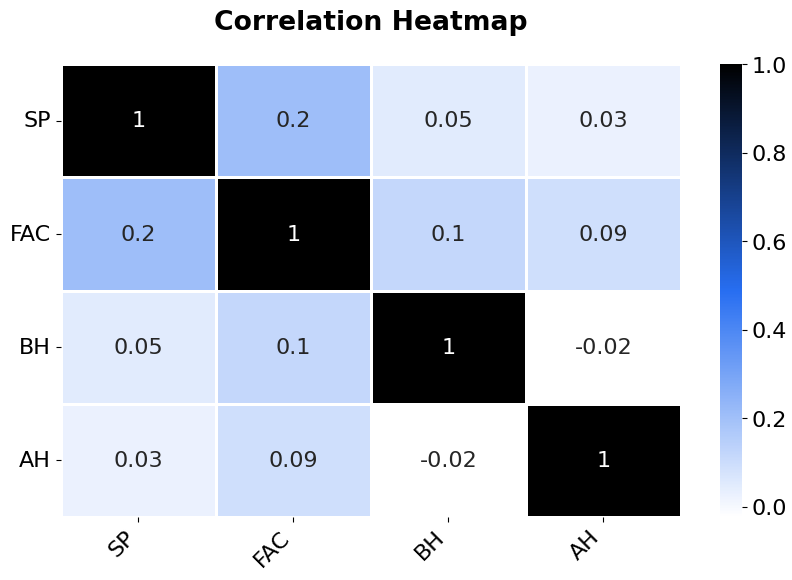

In [68]:
#Correlation plot
#Is there a correlation between our special events and n of customers visiting the credit union?
var_list = ["SP","FAC", "BH", "AH"]
_ = eda_plot.correlation_heatmap(df, var_list = var_list, 
                                 fig_width=10, fig_height=6)

## Test Train Split

In [85]:
#Rename columns
df.rename(columns = {'n_customers': 'y', 'date':'ds'}, inplace = True)

test_size = 254-30
train_df = df[:-test_size]
test_df = df[-test_size:]

print(train_df.tail(3))
print(test_df.head(3))

    MONTH  DAYMON  DAYWEEK  CUST SPECIAL  SP  FAC  BH  AH  year date_string  \
27      2       8        4   695       0   0    0   0   0  1990      199028   
28      2       9        5  1159       0   0    0   0   0  1990      199029   
29      2      12        1   881       0   0    0   0   0  1990     1990212   

           ds     y  
27 1990-02-08   695  
28 1990-02-09  1159  
29 1990-02-12   881  
    MONTH  DAYMON  DAYWEEK  CUST SPECIAL  SP  FAC  BH  AH  year date_string  \
30      2      13        2   768       0   0    0   0   0  1990     1990213   
31      2      14        3   654       0   0    0   0   0  1990     1990214   
32      2      15        4   858       0   0    0   0   0  1990     1990215   

           ds    y  
30 1990-02-13  768  
31 1990-02-14  654  
32 1990-02-15  858  


In [86]:
#We need to initiate a Prophet object
m = Prophet(seasonality_mode='multiplicative')

m.add_regressor(name = 'SP', mode='multiplicative')

#Fit model
m.fit(train_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.


Initial log joint probability = -2.61605
Iteration  1. Log joint probability =    14.1834. Improved by 16.7994.
Iteration  2. Log joint probability =    32.2001. Improved by 18.0167.
Iteration  3. Log joint probability =    41.4631. Improved by 9.26303.
Iteration  4. Log joint probability =    44.1014. Improved by 2.63828.
Iteration  5. Log joint probability =    45.6041. Improved by 1.50267.
Iteration  6. Log joint probability =    45.8652. Improved by 0.261142.
Iteration  7. Log joint probability =    46.1136. Improved by 0.248375.
Iteration  8. Log joint probability =    46.1215. Improved by 0.00792101.
Iteration  9. Log joint probability =    46.1352. Improved by 0.0136895.
Iteration 10. Log joint probability =     46.154. Improved by 0.0187371.
Iteration 11. Log joint probability =    46.2563. Improved by 0.102369.
Iteration 12. Log joint probability =    46.3653. Improved by 0.108922.
Iteration 13. Log joint probability =    46.3775. Improved by 0.0122559.
Iteration 14. Log joint